In [ ]:
!pip install scikit-learn


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import pandas as pd

df = pd.read_csv('online_retail_II.csv')

df_sample = df.head(6000)

df_sample.to_csv('online_retail_sample.csv', index=False)


In [ ]:
df = pd.read_csv("online_retail_II.csv")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [ ]:
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [ ]:
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,243007
Country,0


In [ ]:
df = df.dropna(subset=['Customer ID'])

In [ ]:
df = df[~df['Invoice'].astype(str).str.startswith('C')]

In [ ]:
df = df[df['Quantity'] > 0]

In [ ]:
df['TotalAmount'] = df['Quantity'] * df['Price']

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalAmount': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


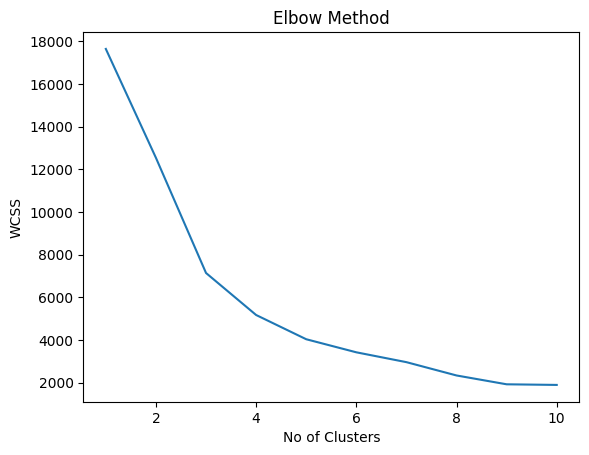

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.xlabel("No of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(rfm_scaled, rfm['KMeans_Cluster'])

np.float64(0.5905397471403384)

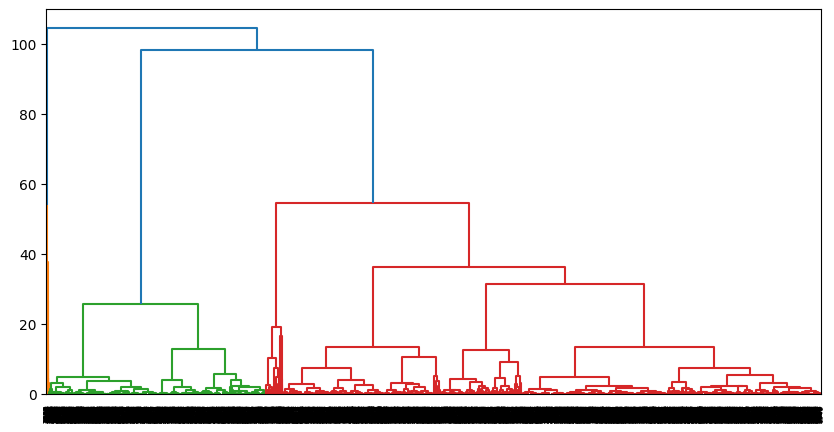

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

linked = linkage(rfm_scaled, method='ward')

plt.figure(figsize=(10,5))
dendrogram(linked)
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.8, min_samples=10)
rfm['DBSCAN_Cluster'] = db.fit_predict(rfm_scaled)


In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, random_state=42)
rfm['GMM_Cluster'] = gmm.fit_predict(rfm_scaled)


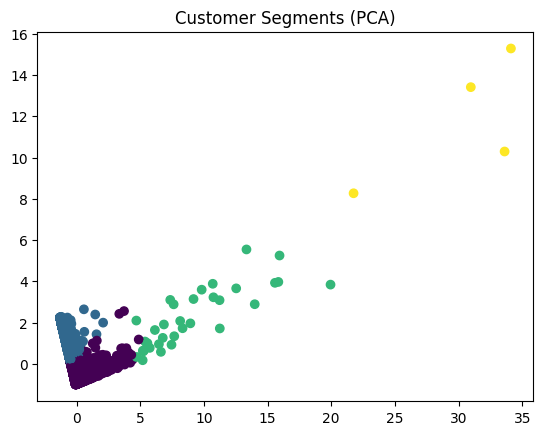

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(rfm_scaled)

plt.scatter(pca_data[:,0], pca_data[:,1], c=rfm['KMeans_Cluster'])
plt.title("Customer Segments (PCA)")
plt.show()


In [ ]:
rfm.groupby('KMeans_Cluster').mean()


,Recency,Frequency,Monetary,DBSCAN_Cluster,GMM_Cluster
KMeans_Cluster,,,,,
0,66.889323,7.307812,3009.123845,-0.003385,0.651302
1,463.034965,2.213287,765.753073,-0.002498,1.060440
2,25.942857,103.742857,83086.079771,-1.000000,2.000000
3,3.500000,212.750000,436835.792500,-1.000000,3.000000
